# Autoencoder 時間序列異常偵測教學

Autoencoder 是一種無監督學習方法，常用於資料降維、特徵學習與異常偵測。

本教學將聚焦於 Autoencoder 在時間序列異常偵測的應用，並以合成資料展示其流程與成效。

**目標：**

- 介紹 Autoencoder 在時間序列異常偵測的理論基礎
- 示範如何使用 Python 實作 Autoencoder 模型進行異常偵測
- 評估模型在異常偵測任務中的表現

## 1. Autoencoder 原理與架構
Autoencoder 是一種無監督學習模型，主要由 Encoder（編碼器）與 Decoder（解碼器）組成，目的是將輸入資料壓縮到潛在空間，再重建回原始資料。其核心流程如下：

- **Encoder**：將高維度輸入資料壓縮成低維度的潛在表示（Latent space）。
- **Decoder**：根據潛在表示，嘗試重建原始資料。

### 直覺理解
可將 Autoencoder 想像成『語言翻譯』：
- 先將英文句子翻譯成西班牙文（壓縮），再翻譯回英文（重建）。
- 若原句正常，來回翻譯後差異不大；若原句有錯誤，重建後會放大錯誤。

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*0Qg9pBpScP5xWh1Ctcv62A.png)

### 時間序列異常偵測流程
1. **輸入資料**：將一段時間序列（或多維向量）輸入 Autoencoder。
2. **重建資料**：模型嘗試重建原始序列。
3. **計算重建誤差**：比較原始與重建序列，常用均方誤差（MSE）作為異常分數。
   - $MSE = \frac{1}{n} \sum_{i=1}^n (x_i - \hat{x}_i)^2$
   - $x_i$ 為原始資料，$\hat{x}_i$ 為重建資料
4. **判斷異常**：重建誤差高者視為異常，低者視為正常。

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ytAOwtuzXKfbA-6xqCmcrA.png)

### 優缺點
- **優點**：
  - 能自動學習資料的正常模式，無需標記異常。
  - 適用於高維度、複雜結構的資料。
- **缺點**：
  - 屬於黑盒模型，解釋性較低，尤其在高維度時更難理解。
  - 需大量正常資料訓練，對異常比例敏感。

### 與其他方法比較
- 傳統方法（如 KNN、DBSCAN）多以距離或密度判斷異常，解釋性較佳。
- Autoencoder 則以重建誤差為依據，能捕捉複雜非線性結構，但需輔以視覺化協助解釋。

### 高維度應用
- 對多特徵時間序列，Autoencoder 可同時學習『時間』與『特徵』間的正常模式。
- 輸入可視為 [features × time] 的影像，異常偵測則如影像異常點偵測。

## 2. 載入並探索資料集

我們將使用 `AirPassengers` 資料集，內容為 1949 至 1960 年每月國際航空旅客總數。資料集將載入並將時間欄設為索引。先顯示前幾列以了解其結構。

In [11]:
# 匯入所需套件
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm

# 載入 AirPassengers 資料集
# https://vincentarelbundock.github.io/Rdatasets/articles/data.html
data = sm.datasets.get_rdataset("AirPassengers", "datasets").data

# 新增時間欄並設為索引
data['time'] = pd.date_range(start='1949-01', periods=len(data), freq='ME')
data.set_index('time', inplace=True)

# 顯示前 24 筆資料
data.head(24)

,value
time,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
1949-06-30,135
1949-07-31,148
1949-08-31,148
1949-09-30,136


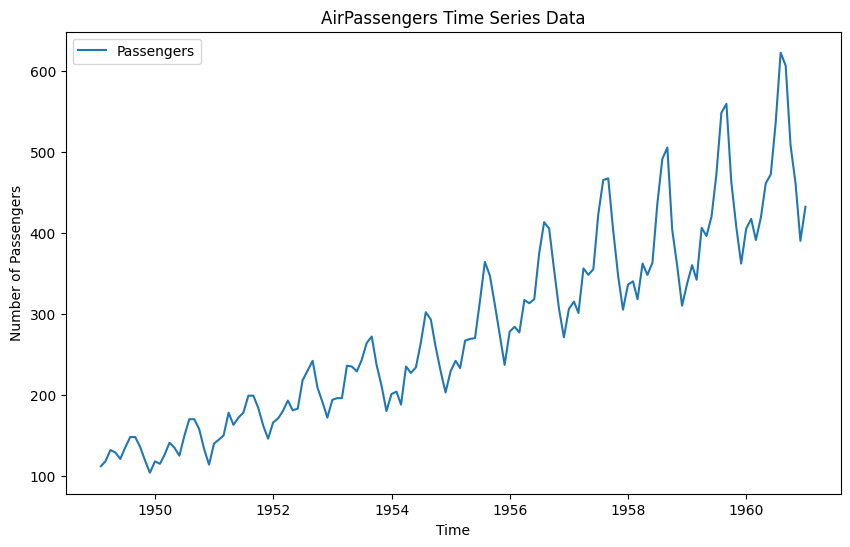

In [12]:
# 視覺化資料分布
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['value'], label='Passengers')
plt.title('AirPassengers Time Series Data')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


## 3. 獲取 STL 殘差組成作為 Autoencoder 輸入

利用 STL 分解時間序列，獲取殘差作為 Autoencoder 的輸入資料

In [13]:
# 利用 STL 分解時間序列，獲取殘差作為 Autoencoder 的輸入資料
stl = STL(data['value'], seasonal=13)
result = stl.fit()

data['residual'] = result.resid

殘差組成代表移除季節性與趨勢後，資料剩餘的變異。以下將擷取並視覺化殘差組成。

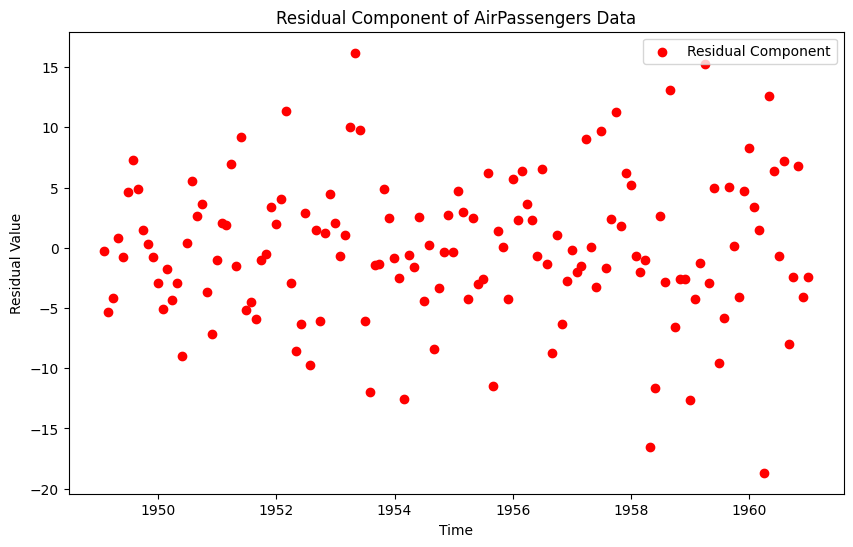

In [14]:
# 擷取並視覺化殘差組成
plt.figure(figsize=(10, 6))
plt.scatter(
  result.resid.index, # 時間索引
  result.resid, # 殘差組成
  label='Residual Component',
  color='red'
)
plt.title('Residual Component of AirPassengers Data')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

## 4. Autoencoder 模型建構與訓練

本範例直接使用 pyod 套件的 AutoEncoder 進行模型建構與訓練，無需手動設計 Keras 結構。

只需指定神經元層數、訓練週期等參數，即可快速完成異常偵測模型。

In [15]:
from pyod.models.auto_encoder import AutoEncoder
from sklearn.preprocessing import MinMaxScaler

# 資料標準化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[['residual']])

# 建立並訓練 pyod autoencoder 模型
ae_model = AutoEncoder(
  hidden_neuron_list=[8, 4, 4, 8],
  epoch_num=30,
  batch_size=32,
  contamination=0.1,
  verbose=0
)
ae_model.fit(X_scaled)

以下是各參數的決定方式與建議：

* `hidden_neuron_list`：決定 autoencoder 結構（每層神經元數）。通常採用「對稱結構」，中間層最少，外層較多。可根據資料維度與複雜度調整，維度高或資料複雜可增加神經元數。
* `epoch_num`：訓練週期，數值越高模型學習越充分，但過高可能過擬合。建議 30~100，視資料量與收斂速度調整。
* `batch_size`：每次訓練的資料筆數。資料量大可用 32~128，資料量小可用 8~32。
* `contamination`：預期異常比例。若已知資料異常比例可直接設定，否則可先用 0.05~0.15 嘗試並觀察結果。
* `verbose`：是否顯示訓練過程，0 為不顯示，1 為顯示。

參數可依資料特性、模型表現（如偵測準確率、重建誤差分布）逐步微調。建議多做交叉驗證與視覺化分析。

## 5. 異常偵測流程

利用 pyod AutoEncoder 直接取得異常分數（decision_scores_）與異常標記（labels_），並以分布圖與標記視覺化異常。

無需手動計算重建誤差或設定閾值，流程更簡潔。

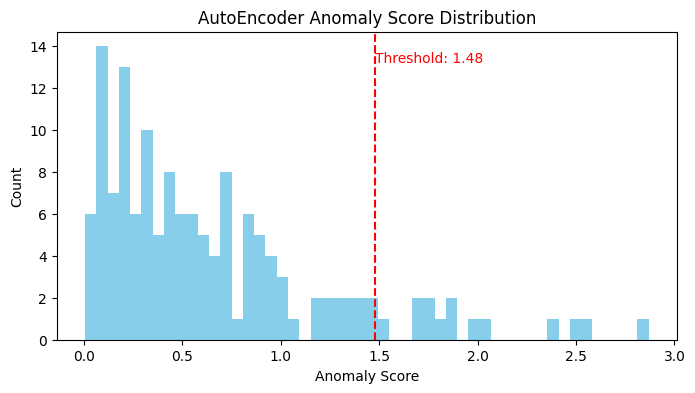

In [16]:
# 取得 pyod autoencoder 異常分數與標記
data['ae_score'] = ae_model.decision_scores_
data['ae_anomaly'] = ae_model.labels_

# 視覺化異常分數分布，包含 threshold 標記
plt.figure(figsize=(8, 4))
plt.hist(data['ae_score'], bins=50, color='skyblue')
plt.axvline(x=ae_model.threshold_, color='red', linestyle='--')
plt.title('AutoEncoder Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
# label the threshold line with value
plt.text(ae_model.threshold_, plt.ylim()[1]*0.9, f'Threshold: {ae_model.threshold_:.2f}', color='red')
plt.show()

## 6. 結果評估與視覺化

將異常點繪製在原始資料上，觀察 Autoencoder 偵測結果與實際資料的關聯性。

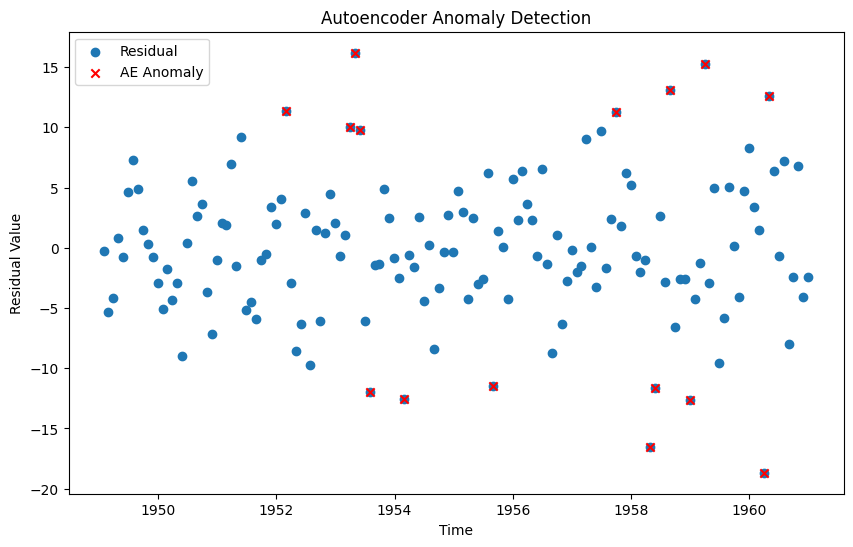

In [17]:
# 標註異常點在 STL Residual 圖上
plt.figure(figsize=(10, 6))
plt.scatter(
  data.index,
  data['residual'],
  label='Residual'
)
plt.scatter(
  data.index[data['ae_anomaly'] == 1],
  data['residual'][data['ae_anomaly'] == 1],
  color='red',
  label='AE Anomaly',
  marker='x'
)
plt.title('Autoencoder Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

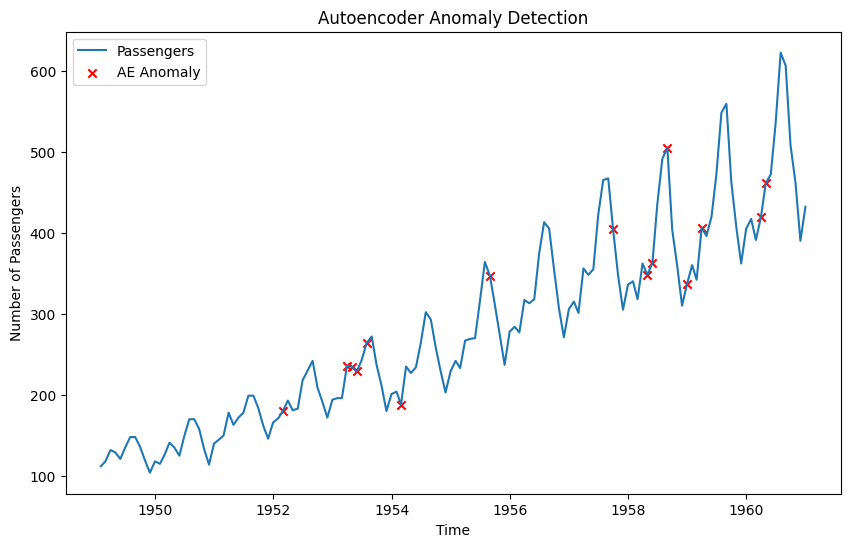

In [18]:
# 將異常點繪製在原始資料上
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['value'], label='Passengers')
plt.scatter(data.index[data['ae_anomaly'] == 1], data['value'][data['ae_anomaly'] == 1], color='red', label='AE Anomaly', marker='x')
plt.title('Autoencoder Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


## 7. 結論與參考資料

- pyod AutoEncoder 可快速建構多維度時間序列異常偵測模型，無需手動設計神經網路結構。

- 直接取得異常分數與標記，流程簡潔且易於視覺化與評估。

- 相關資源：

    - [pyod 官方文件](https://pyod.readthedocs.io/en/latest/)

    - [Autoencoder for Time Series Anomaly Detection (Medium)](https://medium.com/@injure21/autoencoder-for-time-series-anomaly-detection-021d4b9c7909)